# Double pendulum problem

A double pendulum is described in the configuration space by the equations:


In [46]:
from scipy.integrate import solve_ivp
import pandas as pd
import numpy as np
#Libraries for the rendering
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, clear_output, HTML

## Utilities

In [47]:
# Map to convert any angle to the range 0-2pi
def map_to_2pi(alpha):
  k = np.floor(alpha/(2*np.pi)) #Number of complete rotations
  alpha = alpha-k*2*np.pi
  return alpha

# Plot the pendulum
def plot_pendulum(df, color='g'):
  fig, ax = plt.subplots()
  fig.suptitle('Double pendulum')
  
  max = 1.1*np.abs(df['x']).max()
  ax.set_xlim(-max, max)
  ax.set_ylim(-max, max)
  ax.set_aspect('equal')
  ax.grid()
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  
  ax.plot(df['x'], df['y'])

## Lagrangian of the pendulum

,t,theta,v_theta,K,U,E,x,y
0,0.000000,0.800000,2.000000,0.200000,0.068347,0.268347,0.071736,0.069671
1,0.030030,0.892556,4.194445,0.879668,0.061550,0.941219,0.077868,0.062742
2,0.060060,1.054224,6.617409,2.189505,0.048452,2.237957,0.086952,0.049390
3,0.090090,1.292834,9.319726,4.342864,0.026918,4.369783,0.096162,0.027440
4,0.120120,1.616125,12.230461,7.479209,-0.004445,7.474764,0.099897,-0.004531
...,...,...,...,...,...,...,...,...
95,2.852853,0.842772,-3.184248,0.506972,0.065275,0.572247,0.074649,0.066540
96,2.882883,0.779374,-1.059527,0.056130,0.069784,0.125914,0.070283,0.071135
97,2.912913,0.778474,0.999219,0.049922,0.069846,0.119768,0.070219,0.071199
98,2.942943,0.840014,3.120242,0.486795,0.065477,0.552273,0.074465,0.066745


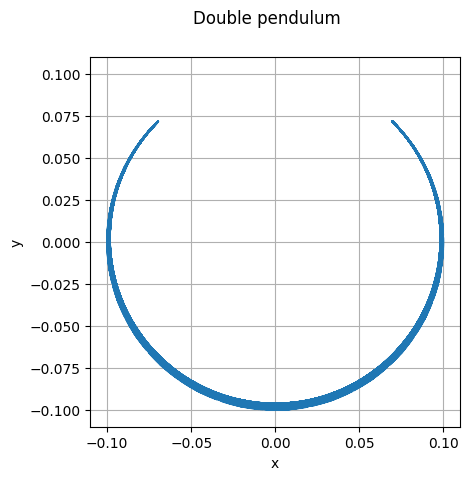

In [48]:
# dy/dt = f(t,y), with y = (theta, dtheta/dt)

def f(t, y, g, r):
  return(y[1], g/r*np.sin(y[0]))

g = 9.81
r = 0.1
m = 0.1

Y = solve_ivp(f, (0,30), y0=(0.8,2.0), method='RK45', args=(g,r), t_eval=np.linspace(0,30,1000), rtol=1e-6)

pendulum_df = pd.DataFrame({'t':Y.t, 'theta': map_to_2pi(Y.y[0]), 'v_theta': Y.y[1]})
pendulum_df['K'] = 0.5*m*pendulum_df['v_theta']**2
pendulum_df['U'] = g*m*r*np.cos(pendulum_df['theta'])
pendulum_df['E'] = pendulum_df['K']+ pendulum_df['U']

pendulum_df['x'] = r*np.sin(pendulum_df['theta'])
pendulum_df['y'] = r*np.cos(pendulum_df['theta'])


plot_pendulum(pendulum_df)
pendulum_df.head(100)